# Hyperparameter tuning 

In [1]:
#essentials
import os
import numpy as np
import pandas as pd
import dataframe_image as dfi
from tqdm import tqdm
import pickle
import warnings
warnings.filterwarnings('ignore')

#visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

#tools/metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split
import shap

#modeling
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

#pandas show all columns
pd.set_option('display.max_columns', None)

#%load_ext autoreload
#%autoreload 2
#%run ./__init__

In [2]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#from fitter import Fitter, get_common_distributions, get_distributions, pd.options.display.max_rows

In [3]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error


In [4]:
kp =  pd.read_csv("D:\\Github\\Capstone-project\\Data folder\\KenPom Team Metrics.csv")
kp_conf_rat =  pd.read_csv("D:\\Github\\Capstone-project\\Data folder\\KP_Conf_Ratings.csv")


In [5]:
kp.head(2)

,Season,TeamName,TeamName 2,Tempo,RankTempo,AdjTempo,RankAdjTempo,OE,RankOE,AdjOE,RankAdjOE,DE,RankDE,AdjDE,RankAdjDE,AdjEM,RankAdjEM,seed
0,2019,ABILENE CHRISTIAN,Abilene Christian,66.5681,293,66.0042,254,107.1020,87,103.625,186,96.7466,43,101.539,119,2.08626,145,15.0
1,2019,AIR FORCE,Air Force,67.2794,269,66.4070,234,98.7687,274,100.431,250,105.6820,242,107.275,238,-6.84432,241,NaN


In [6]:
kp_conf_rat.head(2)

,Year_Conf,Conf_Abb,Conf_Rk,Conf_Full,Conf_Rating,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12
0,2023,Big 12,1,Big 12 Conference,17.99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023,Big Ten,2,Big Ten Conference,14.88,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
#data_path = os.path.dirname(os.getcwd()) + '/data' + '/master_table.csv'
#master_table = pd.read_csv(data_path)
#master_table = pd.read_csv("D:\\Github\\Capstone-project\\Data folder\\final_dataset.csv")

In [8]:
#master_table.head()

In [9]:
#list(master_table.columns)

In [10]:
d = pd.read_csv("D:\\Github\\Capstone-project\\Data folder\\final_data_by_player_type.csv")
d = pd.merge(d, kp, left_on=['Team', 'year'], right_on=['TeamName', 'Season'], how='left')
d = pd.merge(d, kp, left_on=['Team_n1', 'year'], right_on=['TeamName', 'Season'], how='left')
df = pd.merge(d, kp, left_on=['Team_n1', 'year_n1'], right_on=['TeamName', 'Season'], how='left')
df = pd.merge(df, kp_conf_rat, left_on=['conf_abbr', 'year'], right_on=['Conf_Abb', 'Year_Conf'], how='left')
df = pd.merge(df, kp_conf_rat, left_on=['conf_abbr_n1', 'year'], right_on=['Conf_Abb', 'Year_Conf'], how='left')
df = pd.merge(df, kp_conf_rat, left_on=['conf_abbr_n1', 'year_n1'], right_on=['Conf_Abb', 'Year_Conf'], how='left')

#df['offense'] = df['X.Min_n1']*df['ORtg_n1']
df['offense'] = df['X.Min_n1']*df['bpm_n1']  #box plus minus
# (stl_per_poss+blk_per_poss+Dreb%)*%Min
#df['defence'] = (df['stl_per_poss_n1'] + df['blk_per_poss_n1'] + df['drb_pct_n1']) * df['X.Min_n1']

In [11]:
df[['X.Min_n1','mp_per_g','games']].describe()

,X.Min_n1,mp_per_g,games
count,11042.000000,11042.000000,11042.000000
mean,48.420766,19.833680,25.684749
std,25.011647,8.984115,9.599929
min,2.000000,1.600000,1.000000
25%,27.825000,12.100000,20.000000
50%,51.500000,20.300000,28.000000
75%,69.700000,27.400000,31.000000
max,96.500000,38.700000,144.000000


In [12]:
df = df.drop(df[(df['games']<=13) & (df['games_started']/df['games']>0.1)].index)
df = df.drop(df[(df['games_n1']<=13) & (df['games_started_n1']/df['games_n1']>0.1)].index)


df = df.drop(df.loc[((df['games']>39) & (df['year']==2023)) | ((df['games_n1']>39) & (df['year_n1']==2023)) | 
   ((df['games']>40) & (df['year']==2022)) | ((df['games_n1']>40) & (df['year_n1']==2022)) | 
   ((df['games']>33) & (df['year']==2021)) | ((df['games_n1']>33) & (df['year_n1']==2021)) | 
   ((df['games']>35) & (df['year']==2020)) | ((df['games_n1']>35) & (df['year_n1']==2020)) | 
   ((df['games']>40) & (df['year']==2019)) | ((df['games_n1']>40) & (df['year_n1']==2019)) |
   (df['year']==0)]['Player.Name'].index)
idx = df.groupby(['Team', 'year'])['games'].max()
a = pd.DataFrame(idx)
ab = a.reset_index()
ab.columns = ['Team_max', 'year_max', 'games_max']
df = pd.merge(df, ab, left_on=['Team', 'year'], right_on=['Team_max', 'year_max'], how='left')
idx2 = df.groupby(['Team_n1', 'year_n1'])['games_n1'].max()
a2 = pd.DataFrame(idx2)
ab2 = a2.reset_index()
ab2.columns = ['Team_max', 'year_max', 'games_max']
df = pd.merge(df, ab2, left_on=['Team_n1', 'year_n1'], right_on=['Team_max', 'year_max'], how='left')

In [13]:
df = df.drop(df.loc[(df['games_max_x']<15)].index)
df = df.drop(df.loc[(df['games_max_y']<15)].index)

#df = df.drop(df.loc[(df['year']==2020) | (df['year_n1']==2020)].index)
df = df.drop(df[(df['X.Min_n1']<=10)].index)
df = df.drop(df[(df['X.Min']<=10)].index)

In [14]:
# df = df.drop(df[(df['games']<=0.05*df['games_max_x'])].index)
# df = df.drop(df[(df['games_n1']<=0.05*df['games_max_y'])].index)

In [15]:
df = df.drop(df[(df['X.Min_n1']<=10)].index)
df = df.drop(df[(df['X.Min']<=10)].index)
df['Year_dif'] = df['year_n1']-df['year']
df['Team_AdjEM_dif'] = df['AdjEM_y']-df['AdjEM_x']
df['KP_Rk_Dif'] = df['RankAdjEM_y']-df['RankAdjEM_x']
df['KP_Conf_Dif'] = df['Conf_Rating_y']-df['Conf_Rating_x']
df['Calc A'] = df['X.Min']*df['ws']
df['Calc A2'] = df['X.Min']*df['bpm']
df['Calc A3'] = df['X.Min']*df['ORtg']
df['Calc A2_n1'] = df['X.Min_n1']*df['bpm_n1']
df['Calc A_n1'] =df['X.Min_n1']*df['ws_n1']
df['Calc A3_n1'] = df['X.Min_n1']*df['ORtg_n1']
df['Calc B'] = (df['stl_per_poss']+df['blk_per_poss']+df['DR.'])*df['X.Min']
df['Calc B_n1'] = (df['stl_per_poss_n1']+df['blk_per_poss_n1']+df['DR._n1'])*df['X.Min_n1']
df['Calc C']=(df['off_rtg']-df['def_rtg'])*df['X.Min']
df['Calc C_n1']=(df['off_rtg_n1']-df['def_rtg_n1'])*df['X.Min_n1']
df['Calc Overall A'] = df['Calc A'] + df['Calc B']
df['Calc Overall A2'] = df['Calc A2'] + df['Calc B']
df['Calc Overall A3'] = df['Calc A3'] + df['Calc B']
df['Calc Overall A_n1'] = df['Calc A_n1'] + df['Calc B_n1']
df['Calc Overall A2_n1'] = df['Calc A2_n1'] + df['Calc B_n1']
df['Calc Overall A3_n1'] = df['Calc A3_n1'] + df['Calc B_n1']

In [16]:
df[['X.Min_n1','mp_per_g','games', 'offense', 'bpm_n1']].describe()

,X.Min_n1,mp_per_g,games,offense,bpm_n1
count,8078.000000,8078.000000,8078.000000,8059.000000,8059.000000
mean,55.467925,21.753776,27.566353,46.595307,0.225202
std,21.057738,8.021173,6.019344,236.208470,4.121250
min,10.100000,4.800000,4.000000,-855.540000,-29.800000
25%,39.200000,15.100000,24.000000,-108.825000,-2.600000
50%,58.200000,22.300000,29.000000,5.820000,0.100000
75%,72.900000,28.400000,32.000000,179.280000,3.100000
max,96.500000,38.500000,92.000000,1259.200000,16.000000


In [17]:
#len(df[df['bpm_n1']<-10].index)   # 46
df = df.drop(df[(df['bpm_n1']<-10)].index)

In [18]:
#df = df[(df['X.Min_n1']>6) & (df['games']<40)  & (df['games']>7)]
#filtered_df
df[['X.Min_n1','mp_per_g','games', 'offense', 'bpm_n1']].describe()

,X.Min_n1,mp_per_g,games,offense,bpm_n1
count,8032.000000,8032.000000,8032.000000,8013.000000,8013.000000
mean,55.652216,21.790364,27.593003,48.457138,0.295158
std,20.962241,8.013789,6.013128,235.371879,4.021648
min,10.100000,4.800000,4.000000,-855.540000,-10.000000
25%,39.600000,15.100000,24.000000,-107.310000,-2.500000
50%,58.300000,22.300000,29.000000,7.110000,0.200000
75%,72.925000,28.400000,32.000000,180.320000,3.100000
max,96.500000,38.500000,92.000000,1259.200000,16.000000


In [19]:
# Removed rows where Player Season was termed "career"
#indexrows = all_BR_data[all_BR_data['season']=='Career'].index
#all_BR_data.drop(indexrows , inplace=True)

In [20]:
#filtered_df = df[(df['games']<40)  & (df['games']>7)]
#filtered_df[['Team', 'Player.Name', 'X.Min','season' ]].head(3)
#df_to_use = filtered_df.dropna()

In [21]:
#filtered_df1 = filtered_df[filtered_df['mp_per_g'] > 6]
#filtered_df1
#df = filtered_df1

In [22]:
#df = filtered_df

In [23]:
#filtered_df[['X.Min_n1','mp_per_g','games']].describe()

In [24]:
d[['Player.Name','season','Team','year', 'Team_n1', 'year_n1']].head(5)

,Player.Name,season,Team,year,Team_n1,year_n1
0,aamahne-santos-1,2018-19,JACKSONVILLE,2019.0,JACKSONVILLE,2020.0
1,aamir-simms-1,2018-19,CLEMSON,2019.0,CLEMSON,2020.0
2,aamir-simms-1,2019-20,CLEMSON,2020.0,CLEMSON,2021.0
3,aanen-moody-1,2018-19,NORTH DAKOTA,2019.0,NORTH DAKOTA,2020.0
4,aanen-moody-1,2019-20,NORTH DAKOTA,2020.0,SOUTHERN UTAH,2021.0


In [25]:
df[['Player.Name','season','Team','year', 'Team_n1', 'year_n1','Conf_Rating_x', 'Conf_Rating_y', 'offense']].head(5)

,Player.Name,season,Team,year,Team_n1,year_n1,Conf_Rating_x,Conf_Rating_y,offense
0,aamahne-santos-1,2018-19,JACKSONVILLE,2019.0,JACKSONVILLE,2020.0,-4.43,-4.43,-258.40
1,aamir-simms-1,2018-19,CLEMSON,2019.0,CLEMSON,2020.0,15.33,15.33,596.45
2,aamir-simms-1,2019-20,CLEMSON,2020.0,CLEMSON,2021.0,11.45,11.45,642.06
5,aanen-moody-1,2020-21,SOUTHERN UTAH,2021.0,SOUTHERN UTAH,2022.0,-4.89,-4.89,42.57
6,aanen-moody-1,2021-22,SOUTHERN UTAH,2022.0,MONTANA,2023.0,-7.27,-7.27,131.24


In [26]:
kp.head(2)

,Season,TeamName,TeamName 2,Tempo,RankTempo,AdjTempo,RankAdjTempo,OE,RankOE,AdjOE,RankAdjOE,DE,RankDE,AdjDE,RankAdjDE,AdjEM,RankAdjEM,seed
0,2019,ABILENE CHRISTIAN,Abilene Christian,66.5681,293,66.0042,254,107.1020,87,103.625,186,96.7466,43,101.539,119,2.08626,145,15.0
1,2019,AIR FORCE,Air Force,67.2794,269,66.4070,234,98.7687,274,100.431,250,105.6820,242,107.275,238,-6.84432,241,NaN


In [27]:
kp_conf_rat.head(2)

,Year_Conf,Conf_Abb,Conf_Rk,Conf_Full,Conf_Rating,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12
0,2023,Big 12,1,Big 12 Conference,17.99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023,Big Ten,2,Big Ten Conference,14.88,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
list(df.columns)

['Unnamed: 0',
 'player_type',
 'Team',
 'Team_n1',
 'Unnamed..0_x',
 'Player.Name',
 'season',
 'conf_abbr',
 'games',
 'games_started',
 'mp_per_g',
 'fg_per_g',
 'fga_per_g',
 'fg_pct',
 'fg2_per_g',
 'fg2a_per_g',
 'fg2_pct',
 'fg3_per_g',
 'fg3a_per_g',
 'fg3_pct',
 'ft_per_g',
 'fta_per_g',
 'ft_pct',
 'orb_per_g',
 'drb_per_g',
 'trb_per_g',
 'ast_per_g',
 'stl_per_g',
 'blk_per_g',
 'tov_per_g',
 'pf_per_g',
 'pts_per_g',
 'sos',
 'mp',
 'fg',
 'fga',
 'fg2',
 'fg2a',
 'fg2_pct.1',
 'fg3',
 'fg3a',
 'ft',
 'fta',
 'orb',
 'drb',
 'trb',
 'ast',
 'stl',
 'blk',
 'tov',
 'pf',
 'pts',
 'fg_per_min',
 'fga_per_min',
 'fg2_per_min',
 'fg2a_per_min',
 'fg3_per_min',
 'fg3a_per_min',
 'ft_per_min',
 'fta_per_min',
 'trb_per_min',
 'ast_per_min',
 'stl_per_min',
 'blk_per_min',
 'tov_per_min',
 'pf_per_min',
 'pts_per_min',
 'fg_per_poss',
 'fga_per_poss',
 'fg2_per_poss',
 'fg2a_per_poss',
 'fg3_per_poss',
 'fg3a_per_poss',
 'ft_per_poss',
 'fta_per_poss',
 'trb_per_poss',
 'ast_per_

In [32]:
to_use= list(df.columns[(df. dtypes == 'float64') | (df. dtypes == 'int64') ])
len(to_use)
to_use

['Unnamed: 0',
 'player_type',
 'Unnamed..0_x',
 'games',
 'games_started',
 'mp_per_g',
 'fg_per_g',
 'fga_per_g',
 'fg2_per_g',
 'fg2a_per_g',
 'fg3_per_g',
 'fg3a_per_g',
 'ft_per_g',
 'fta_per_g',
 'orb_per_g',
 'drb_per_g',
 'trb_per_g',
 'ast_per_g',
 'stl_per_g',
 'blk_per_g',
 'tov_per_g',
 'pf_per_g',
 'pts_per_g',
 'sos',
 'mp',
 'fg',
 'fga',
 'fg2',
 'fg2a',
 'fg3',
 'fg3a',
 'ft',
 'fta',
 'orb',
 'drb',
 'trb',
 'ast',
 'stl',
 'blk',
 'tov',
 'pf',
 'pts',
 'fg_per_min',
 'fga_per_min',
 'fg2_per_min',
 'fg2a_per_min',
 'fg3_per_min',
 'fg3a_per_min',
 'ft_per_min',
 'fta_per_min',
 'trb_per_min',
 'ast_per_min',
 'stl_per_min',
 'blk_per_min',
 'tov_per_min',
 'pf_per_min',
 'pts_per_min',
 'fg_per_poss',
 'fga_per_poss',
 'fg2_per_poss',
 'fg2a_per_poss',
 'fg3_per_poss',
 'fg3a_per_poss',
 'ft_per_poss',
 'fta_per_poss',
 'trb_per_poss',
 'ast_per_poss',
 'stl_per_poss',
 'blk_per_poss',
 'tov_per_poss',
 'pf_per_poss',
 'pts_per_poss',
 'off_rtg',
 'def_rtg',
 'per',

In [34]:
df = df.replace(to_replace="NO IDEA",value=0)
df = df.replace(to_replace="---",value=0)
df = df.fillna(0)
pd.options.display.max_columns

In [35]:
#columns = ['games','games_started','mp_per_g','fg_per_g','fga_per_g','fg2_per_g','fg2a_per_g','fg3_per_g','fg3a_per_g','ft_per_g','fta_per_g','orb_per_g','drb_per_g','trb_per_g','ast_per_g','stl_per_g','blk_per_g','tov_per_g','pf_per_g','pts_per_g','sos','mp','fg','fga','fg2','fg2a','fg3','fg3a','ft','fta','orb','drb','trb','ast','stl','blk','tov','pf','pts','fg_per_min','fga_per_min','fg2_per_min','fg2a_per_min','fg3_per_min','fg3a_per_min','ft_per_min','fta_per_min','trb_per_min','ast_per_min','stl_per_min','blk_per_min','tov_per_min','pf_per_min','pts_per_min','fg_per_poss','fga_per_poss','fg2_per_poss','fg2a_per_poss','fg3_per_poss','fg3a_per_poss','ft_per_poss','fta_per_poss','trb_per_poss','ast_per_poss','stl_per_poss','blk_per_poss','tov_per_poss','pf_per_poss','pts_per_poss','off_rtg','def_rtg','per','ts_pct','efg_pct','fg3a_per_fga_pct','fta_per_fga_pct','pprod','orb_pct','drb_pct','trb_pct','ast_pct','stl_pct','blk_pct','tov_pct','usg_pct','ows','dws','ws','ws_per_40','obpm','dbpm','bpm','year','Ht','Wt','G','S','X.Min','ORtg','X.Poss','X.Shots','eFG.','TS.','OR.','DR.','ARate','TORate','Blk.','Stl.','FC.40','FD.40','FTRate','Pct.2','X.Pct','X.Pct.1','Season_x','Tempo_x','RankTempo_x','AdjTempo_x','RankAdjTempo_x','OE_x','RankOE_x','AdjOE_x','RankAdjOE_x','DE_x','RankDE_x','AdjDE_x','RankAdjDE_x','AdjEM_x','RankAdjEM_x','seed_x','Season_y','Tempo_y','RankTempo_y','AdjTempo_y','RankAdjTempo_y','OE_y','RankOE_y','AdjOE_y','RankAdjOE_y','DE_y','RankDE_y','AdjDE_y','RankAdjDE_y','AdjEM_y','RankAdjEM_y','seed_y', 'Year_Conf_x','Conf_Rk_x','Conf_Rating_x','Year_Conf_y','Conf_Rk_y','Conf_Rating_y']
columns = ['player_type', 'games', 'games_started', 'mp_per_g', 'fg_per_g', 'fga_per_g', 'fg2_per_g', 'fg2a_per_g', 'fg3_per_g', 'fg3a_per_g', 'ft_per_g', 'fta_per_g', 'orb_per_g', 'drb_per_g', 'trb_per_g', 'ast_per_g', 'stl_per_g', 'blk_per_g', 'tov_per_g', 'pf_per_g', 'pts_per_g', 'sos', 'mp', 'fg', 'fga', 'fg2', 'fg2a', 'fg3', 'fg3a', 'ft', 'fta', 'orb', 'drb', 'trb', 'ast', 'stl', 'blk', 'tov', 'pf', 'pts', 'fg_per_min', 'fga_per_min', 'fg2_per_min', 'fg2a_per_min', 'fg3_per_min', 'fg3a_per_min', 'ft_per_min', 'fta_per_min', 'trb_per_min', 'ast_per_min', 'stl_per_min', 'blk_per_min', 'tov_per_min', 'pf_per_min', 'pts_per_min', 'fg_per_poss', 'fga_per_poss', 'fg2_per_poss', 'fg2a_per_poss', 'fg3_per_poss', 'fg3a_per_poss', 'ft_per_poss', 'fta_per_poss', 'trb_per_poss', 'ast_per_poss', 'stl_per_poss', 'blk_per_poss', 'tov_per_poss', 'pf_per_poss', 'pts_per_poss', 'off_rtg', 'def_rtg', 'per', 'ts_pct', 'efg_pct', 'fg3a_per_fga_pct', 'fta_per_fga_pct', 'pprod', 'orb_pct', 'drb_pct', 'trb_pct', 'ast_pct', 'stl_pct', 'blk_pct', 'tov_pct', 'usg_pct', 'ows', 'dws', 'ws', 'ws_per_40', 'obpm', 'dbpm', 'bpm', 'year', 'Ht', 'Wt', 'G', 'S', 'X.Min', 'ORtg', 'X.Poss', 'X.Shots', 'eFG.', 'TS.', 'OR.', 'DR.', 'ARate', 'TORate', 'Blk.', 'Stl.', 'FC.40', 'FD.40', 'FTRate', 'Pct.2', 'X.Pct', 'X.Pct.1', 'Season_x', 'Tempo_x', 'RankTempo_x', 'AdjTempo_x', 'RankAdjTempo_x', 'OE_x', 'RankOE_x', 'AdjOE_x', 'RankAdjOE_x', 'DE_x', 'RankDE_x', 'AdjDE_x', 'RankAdjDE_x', 'AdjEM_x', 'RankAdjEM_x', 'seed_x', 'Season_y', 'Tempo_y', 'RankTempo_y', 'AdjTempo_y', 'RankAdjTempo_y', 'OE_y', 'RankOE_y', 'AdjOE_y', 'RankAdjOE_y', 'DE_y', 'RankDE_y', 'AdjDE_y', 'RankAdjDE_y', 'AdjEM_y', 'RankAdjEM_y', 'seed_y', 'Year_Conf_x', 'Conf_Rk_x', 'Conf_Rating_x', 'Year_Conf_y', 'Conf_Rk_y', 'Conf_Rating_y', 'year_max_x', 'games_max_x', 'year_max_y', 'games_max_y', 'Team_AdjEM_dif', 'KP_Rk_Dif', 'KP_Conf_Dif', 'Calc A', 'Calc A2', 'Calc A3', 'Calc B', 'Calc C', 'Calc Overall A', 'Calc Overall A2', 'Calc Overall A3']
 


In [36]:
master_table  = df[columns]
print(master_table.shape)

(8032, 169)


In [37]:
y = df['offense'].to_frame()
y.shape

(8032, 1)

In [38]:
from sklearn.decomposition import PCA

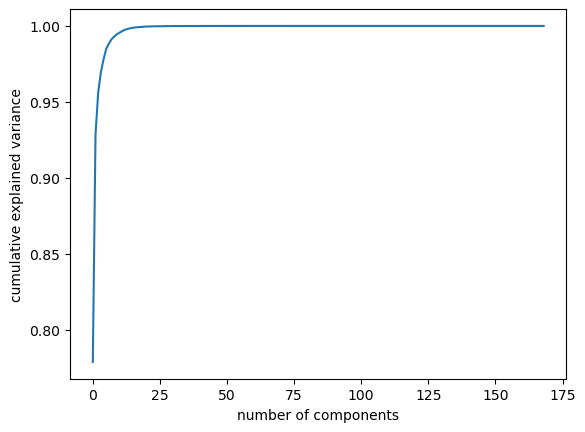

In [39]:
pca = PCA().fit(master_table)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [40]:
pca = PCA(n_components=15)
projected= pca.fit_transform(master_table)
print(projected.shape)

(8032, 15)


In [41]:
pca_components = pd.DataFrame(projected)

In [42]:
pca_components.head(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,2036.178138,-613.938754,1663.020801,-553.399841,-74.432322,294.875850,66.106587,-163.914920,164.550167,26.767678,82.341192,178.049604,-132.183726,67.128090,-95.228081
1,2885.485715,-602.488622,-274.981549,39.448522,-68.640777,325.366039,-221.876455,280.971399,-141.379001,-24.171617,-35.006703,148.698271,-29.889696,59.411734,-95.283806


In [43]:
pca_components.shape

(8032, 15)

In [44]:
# split the data with 90% in training set
X_train, X_test, y_train, y_test = train_test_split(master_table, y, random_state=0,
                                    train_size=0.9)


In [45]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(7228, 169)
(804, 169)
(7228, 1)
(804, 1)


In [46]:
model_params = {
    
    'random_forest': {
        'model': RandomForestRegressor(),
        'params' : {
            'n_estimators': [1,5,10,20, 25, 30, 50],
            'max_depth':[2,4,6,8,10,12]
        }
    },
    
    'naive_bayes_gaussian': {
        'model': SVR(),
        'params': {
            'C': [0.4, 0.6, 0.8, 1],
            'epsilon': [0.01, 0.02, 0.04, 0.06, 0.08, 0.1]
        }
    },
    
    'xg_boost':  {
        'model': XGBRegressor(),
        'params' : {
            'max_depth' : [2,4, 6, 8, 10, 15, 20],
            'learning_rate' : [0.1, 0.25, 0.5, 0.75],
            'subsample' : [0.5],
            'min_child_weight' : [0.1, 0.25, 0.5, 0.75]
        }
        
    }

      
}

In [47]:
from sklearn.model_selection import GridSearchCV
import pandas as pd
scores = []

for model_name, mp in model_params.items():
    rgr =  GridSearchCV(mp['model'], mp['params'], cv=5, return_train_score=False)
    rgr.fit(X_train, y_train)
    print(f" model --> {model_name} done ")
    scores.append({
        'model': model_name,
        'best_score': rgr.best_score_,
        'best_params': rgr.best_params_
    })
    
df_params = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df_params

 model --> random_forest done 
 model --> naive_bayes_gaussian done 
 model --> xg_boost done 


,model,best_score,best_params
0,random_forest,0.563791,"{'max_depth': 10, 'n_estimators': 50}"
1,naive_bayes_gaussian,0.160194,"{'C': 1, 'epsilon': 0.08}"
2,xg_boost,0.574267,"{'learning_rate': 0.1, 'max_depth': 4, 'min_ch..."


In [ ]:
df_params.to_csv("D:\\Github\\Capstone-project\\Data folder\\hyperparameter_tuning_offense.csv", index=False)

In [48]:
df_params['best_params'].iloc[2]

{'learning_rate': 0.1,
 'max_depth': 4,
 'min_child_weight': 0.1,
 'subsample': 0.5}

In [ ]:
#df_params_pca = df_params

In [ ]:
df_params_pca.head()